In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [44]:
aapl = pd.read_csv('AAPL_CLOSE',index_col='Date',parse_dates=True)
cisco = pd.read_csv('CISCO_CLOSE',index_col='Date',parse_dates=True)
ibm = pd.read_csv('IBM_CLOSE',index_col='Date',parse_dates=True)
amzn = pd.read_csv('AMZN_CLOSE',index_col='Date',parse_dates=True)

In [45]:
stocks= pd.concat([aapl,cisco,ibm,amzn],axis=1)
stocks.columns=['aapl','cisco','ibm','amzn']

In [46]:
stocks.head()

,aapl,cisco,ibm,amzn
Date,,,,
2012-01-03,53.063218,15.752778,160.830881,179.03
2012-01-04,53.348386,16.057180,160.174781,177.51
2012-01-05,53.940658,15.997991,159.415086,177.61
2012-01-06,54.504543,15.938801,157.584912,182.61
2012-01-09,54.418089,16.040268,156.764786,178.56


In [47]:
#mean daily return
stocks.pct_change(1).mean()

aapl     0.000750
cisco    0.000599
ibm      0.000081
amzn     0.001328
dtype: float64

In [48]:
#daily return
daily_ret=stocks.pct_change(1)

In [49]:
#correlation btw. returns --> detrending
stocks.pct_change(1).corr()

,aapl,cisco,ibm,amzn
aapl,1.000000,0.301990,0.297498,0.235487
cisco,0.301990,1.000000,0.424672,0.284470
ibm,0.297498,0.424672,1.000000,0.258492
amzn,0.235487,0.284470,0.258492,1.000000


In [50]:
#log returns
log_ret=np.log(stocks/stocks.shift(1))

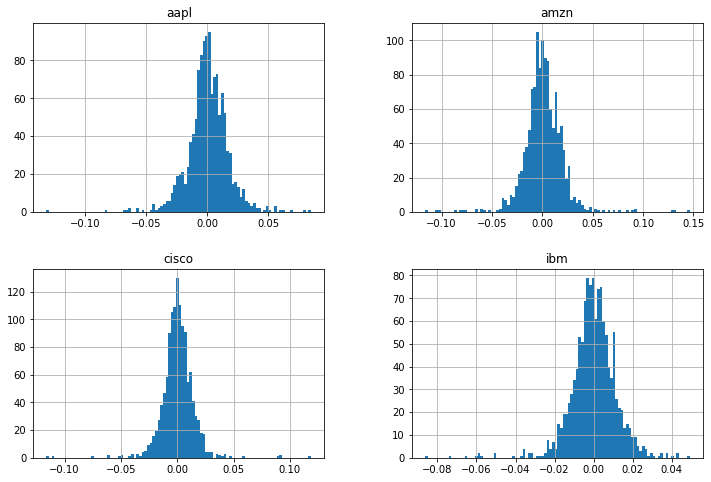

In [51]:
log_ret.hist(bins=100,figsize=(12,8))
plt.tight_layout;

In [52]:
log_ret.mean()

aapl     0.000614
cisco    0.000497
ibm      0.000011
amzn     0.001139
dtype: float64

In [53]:
#covariance of col
log_ret.cov()*252

,aapl,cisco,ibm,amzn
aapl,0.068326,0.017854,0.014464,0.018986
cisco,0.017854,0.051381,0.018029,0.019956
ibm,0.014464,0.018029,0.035203,0.014939
amzn,0.018986,0.019956,0.014939,0.094470


In [54]:
np.random.seed(101)

print(stocks.columns)
print('\n')

#weights
print('Random Weights')
weights=np.array(np.random.random(4))
print(weights)
print('\n')

print('Rebalances')
weights= weights/np.sum(weights)
print(weights)
print('\n')

#Expected Return
print('Expected Portfolio Return')
exp_ret=np.sum((log_ret.mean()*weights)*252)
print(exp_ret)
print('\n')

#Expected Variance (volatility)
print('Expected Volatility')
exp_vol=np.sqrt(np.dot(weights.T,np.dot(log_ret.cov()*252,weights)))
print(exp_vol)
print('\n')

#Sharpe Ratio
print('Sharpe Ratio')
SR= exp_ret/exp_vol
print(SR)

Index(['aapl', 'cisco', 'ibm', 'amzn'], dtype='object')


Random Weights
[0.51639863 0.57066759 0.02847423 0.17152166]


Rebalances
[0.40122278 0.44338777 0.02212343 0.13326603]


Expected Portfolio Return
0.15599272049632004


Expected Volatility
0.18502649565909488


Sharpe Ratio
0.8430831483926032


In [55]:
np.random.seed(101)

num_ports=25000
all_weights=np.zeros((num_ports,len(stocks.columns)))
ret_arr = np.zeros(num_ports)
vol_arr = np.zeros(num_ports)
sharpe_arr = np.zeros(num_ports)

for ind in range(num_ports):
    #weights
    weights=np.array(np.random.random(4))
    weights= weights/np.sum(weights)   #Rebalance

    #Save weights
    all_weights[ind,:] = weights
    
    #Expected Return
    ret_arr[ind]=np.sum((log_ret.mean()*weights)*252)


    #Expected Variance (volatility)
    vol_arr[ind]=np.sqrt(np.dot(weights.T,np.dot(log_ret.cov()*252,weights)))

    #Sharpe Ratio
    sharpe_arr[ind]= ret_arr[ind]/vol_arr[ind]

In [56]:
sharpe_arr.max()

1.0303260551271067

In [57]:
sharpe_arr.argmax()

1420

In [58]:
all_weights[sharpe_arr.argmax(),:]

array([0.26188068, 0.20759516, 0.00110226, 0.5294219 ])

In [59]:
max_sr_return= ret_arr[sharpe_arr.argmax()]
max_sr_vol= vol_arr[sharpe_arr.argmax()]

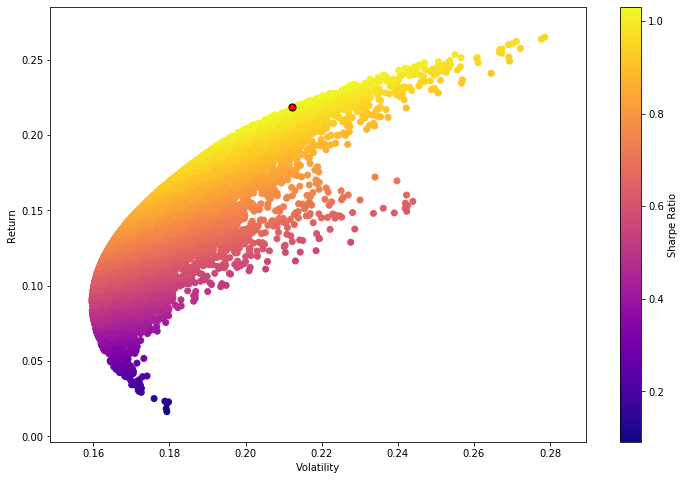

In [60]:
#plot data
plt.figure(figsize=(12,8))
plt.scatter(vol_arr,ret_arr,c=sharpe_arr,cmap='plasma')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')

#dot max SR
plt.scatter(max_sr_vol,max_sr_return, c='red',s=50, edgecolors='black')

In [80]:
#math optimisatin

In [81]:
#fn weights, return, SR
def get_ret_vol_sr(weights):
    weights= np.array(weights)
    ret = np.sum(log_ret.mean() * weights) * 252
    vol= np.sqrt(np.dot(weights.T,np.dot(log_ret.cov()*252,weights)))
    sr= ret/vol
    
    return np.array([ret,vol,sr])

In [82]:
from scipy.optimize import minimize

In [83]:
#helper fn
def neg_sharpe(weights):
    return get_ret_vol_sr(weights)[2]*-1   #Sr is index 2, negative SR with *-1

In [84]:
#constraints
def check_sum(weights):
    return np.sum(weights)-1  #return 0 if summ of weights is 1 or difference


In [85]:
#constraints
cons= ({'type':'eq','fun':check_sum})   #the constraints is equation type

In [86]:
bounds= ((0,1),(0,1),(0,1),(0,1)) #4weights are btw. 0,1

In [87]:
init_guess=[0.25,0.25,0.25,0.25]

In [88]:
opt_results= minimize(neg_sharpe,init_guess,method='SLSQP',bounds=bounds,constraints=cons)

In [89]:
opt_results

     fun: -1.0307168703342362
     jac: array([ 5.64455986e-05,  4.18573618e-05,  3.39921728e-01, -4.44948673e-05])
 message: 'Optimization terminated successfully.'
    nfev: 42
     nit: 7
    njev: 7
  status: 0
 success: True
       x: array([2.66289774e-01, 2.04189831e-01, 7.52707358e-17, 5.29520395e-01])

In [90]:
opt_results.x

array([2.66289774e-01, 2.04189831e-01, 7.52707358e-17, 5.29520395e-01])

In [91]:
get_ret_vol_sr(opt_results.x)

array([0.21885915, 0.21233683, 1.03071687])

In [92]:
#efficient frontier (ie. set of optimal portfolio)

In [93]:
# Our returns go from 0 to somewhere along 0.3
# Create a linspace number of points to calculate x on
frontier_y = np.linspace(0,0.3,100) # Change 100 to a lower number for slower computers!

In [94]:
def minimize_volatility(weights):
    return  get_ret_vol_sr(weights)[1]   #volatility is index 1

In [95]:
frontier_volatility = []

for possible_return in frontier_y:
    # function for return
    cons = ({'type':'eq','fun': check_sum},
            {'type':'eq','fun': lambda w: get_ret_vol_sr(w)[0] - possible_return})
    
    result = minimize(minimize_volatility,init_guess,method='SLSQP',bounds=bounds,constraints=cons)
    
    frontier_volatility.append(result['fun'])

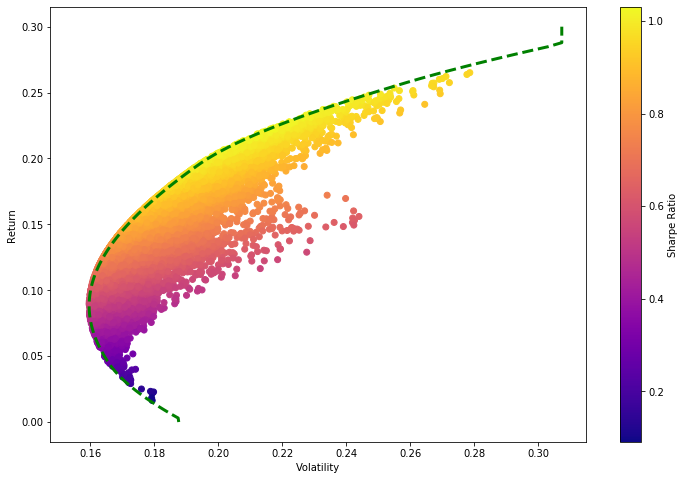

In [79]:
plt.figure(figsize=(12,8))
plt.scatter(vol_arr,ret_arr,c=sharpe_arr,cmap='plasma')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')



# Add frontier line
plt.plot(frontier_volatility,frontier_y,'g--',linewidth=3)